## Training CNN or DNN on MNIST and Noisy MNIST dataset (n-MNIST)

- A DNN network
- A Simple CNN network
- A Normal CNN network

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

### The neuros setting of hidden layer

In [2]:
neuros = 500
# neuros = 200

### 1, Deep Neural Network (DNN)

In [3]:
class DNNNet(nn.Module):
    def __init__(self):
        super(DNNNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):

        x = x.view(-1, 28 * 28 * 1)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### 2, Simple Convolutional Neural Network(SCNN)

In [4]:
class SimpleCNNNet(nn.Module):
    def __init__(self):
        super(SimpleCNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.fc1 = nn.Linear(12 * 12 * 20, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 12 * 12 * 20)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### 3, Convolutional Neural Network (CNN)

In [5]:
class CNNNet(nn.Module):

    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, neuros)
        self.fc2 = nn.Linear(neuros, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Training Models

In [6]:
#!/usr/bin/env python
"""
Train a basic MNIST CNN.
Based on the PyTorch example code here:
https://github.com/pytorch/examples/blob/master/mnist/main.py
"""
from __future__ import print_function
import os
import sys
import argparse
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.nn.functional as F
import errno
import scipy.io as sio
import numpy as np

#### 1, Training the models on MNIST datasets

In [7]:
from torchvision.datasets import MNIST
from torchvision.datasets.utils import download_url

#### 2,Training the models on Noisy MNIST dataset

In [8]:
class NMNIST(MNIST):
    """`n-MNIST <http://www.csc.lsu.edu/~saikat/n-mnist/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where ``mnist-with-awgn.mat``,
            ``mnist-with-motion-blur.mat`` and
            ``mnist-with-reduced-contrast-and-awgn.mat`` exist.
        train (bool, optional): If True, loads training data, otherwise loads
            test data.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        dataset (string, optional): Select the particular n-MNIST dataset to load:
            "awgn", "motion-blur", "reduced-contrast-and-awgn" or "all".
    """
    urls = {
        'awgn': 'http://www.csc.lsu.edu/~saikat/n-mnist/data/mnist-with-awgn.gz',
        'motion-blur': 'http://www.csc.lsu.edu/~saikat/n-mnist/data/mnist-with-motion-blur.gz',
        'reduced-contrast-and-awgn': 'http://www.csc.lsu.edu/~saikat/n-mnist/data/mnist-with-reduced-contrast-and-awgn.gz',
    }

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, dataset='awgn'):
        self.dataset = dataset

        if self.dataset != 'all':
            self.urls = {self.dataset: self.urls[self.dataset]}

        self.gzip_files = []
        self.mat_files = []
        for _, url in self.urls.items():
            self.gzip_files.append(os.path.basename(url))
            self.mat_files.append(os.path.splitext(os.path.basename(url))[0] + '.mat')

        self.training_file = self.dataset + '-training.pt'
        self.test_file = self.dataset + '-test.pt'
        print('----0', root)
        super(NMNIST, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)

    def _check_gzips_exists(self):
        for gzip_file in self.gzip_files:
            print('----4',os.path.join('', self.raw_folder, gzip_file))
            if not os.path.exists(os.path.join('', self.raw_folder, gzip_file)):
                return False
        return True

    def _check_mats_exists(self):
        for mat_file in self.mat_files:
            print('----5',os.path.join('', self.raw_folder, mat_file))
            if not os.path.exists(os.path.join('', self.raw_folder, mat_file)):
                return False
        return True

    def download(self):
        """Download the n-MNIST data if it doesn't exist in processed_folder already."""
        from six.moves import urllib
        import tarfile

        if self._check_exists():
            return

        # download files
        try:
            print('----1',os.path.join('', self.raw_folder))
            os.makedirs(os.path.join('', self.raw_folder))
            print('----2',os.path.join('', self.processed_folder))
            os.makedirs(os.path.join('', self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        if not self._check_mats_exists():
            for _, url in self.urls.items():
                filename = url.rpartition('/')[2]
                file_path = os.path.join('', self.raw_folder, filename)
                print('----3',os.path.join('', self.raw_folder, filename))
                print('----4',os.path.join('', self.raw_folder))
                if not self._check_gzips_exists():
                    download_url(url, root=os.path.join('', self.raw_folder),
                                 filename=filename, md5=None)
                with open(file_path.replace('.gz', '.mat'), 'wb') as out_f:
                    tar = tarfile.open(file_path, 'r:gz')
                    zip_f = tar.extractfile(os.path.basename(file_path.replace('.gz', '.mat')))
                    out_f.write(zip_f.read())
                    os.unlink(file_path)

        # process and save as torch files
        print('Processing...')

        def read_images(mat_data, split):
            length = mat_data[split].shape[0]
            num_rows = np.uint8(np.sqrt(mat_data[split].shape[1]))
            num_cols = num_rows
            return torch.from_numpy(mat_data[split]).view(length, num_rows, num_cols)

        def read_labels(mat_data, split):
            length = mat_data[split].shape[0]
            labels = np.asarray([np.where(r == 1)[0][0] for r in mat_data[split]])
            return torch.from_numpy(labels).view(length).long()

        data = sio.loadmat(os.path.join('', self.raw_folder, self.mat_files[0]))
        if len(self.mat_files) > 1:
            for mat_file in self.mat_files[1:]:
                mat_data = sio.loadmat(os.path.join('', self.raw_folder, mat_file))
                data['train_x'] = np.concatenate((data['train_x'], mat_data['train_x']), axis=0)
                data['train_y'] = np.concatenate((data['train_y'], mat_data['train_y']), axis=0)
                data['test_x'] = np.concatenate((data['test_x'], mat_data['test_x']), axis=0)
                data['test_y'] = np.concatenate((data['test_y'], mat_data['test_y']), axis=0)

        training_set = (
            read_images(data, 'train_x'),
            read_labels(data, 'train_y')
        )
        test_set = (
            read_images(data, 'test_x'),
            read_labels(data, 'test_y')
        )
        with open(os.path.join('', self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join('', self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

In [9]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if False:
                break

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return round((100. * correct / len(test_loader.dataset)),3)

In [11]:
# hpyerparameters settings
learning_rate = 0.01
step_size=1
gamma=0.7
momentum = 0.5
epoch_num = 10
seed = 1
train_batch_size = 64
test_batch_size = 1000
model_save_path = '../cnn_trained/' 
net_list = ['dnn', 'scnn', 'cnn']

In [12]:
def execute_train(dataset, epoch_num=10):
    
    accuracys = []
    dataset_name = ''
    for net in net_list:
        print('=====================', net,'======================')
        # Training settings
        use_cuda = not False and torch.cuda.is_available()
        accuracy_list = []
        torch.manual_seed(seed)

        device = torch.device("cuda" if use_cuda else "cpu")

        kwargs = {}
        if use_cuda:
            torch.cuda.manual_seed(seed)
            kwargs = {'num_workers': 1,'pin_memory': True}

        # load the mnist dataset
        if dataset == 'mnist':
            data_path = './data/mnist/'
            dataset_name = 'mnist'
            train_loader = torch.utils.data.DataLoader(
                datasets.MNIST(data_path, 
                               train=True, 
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])),
                batch_size=train_batch_size, shuffle=True, **kwargs)

            test_loader = torch.utils.data.DataLoader(
                datasets.MNIST(data_path,
                               train=False,
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor(),
                                                             transforms.Normalize((0.1307,), (0.3081,))])),
                batch_size=test_batch_size, shuffle=True, **kwargs)
        # load the n-mnist dataset
        elif dataset == 'awgn' or 'motion-blur' or 'reduced-contrast-and-awgn':
            data_path = './data/n-mnist/'
            dataset_name = 'mnist-' + dataset
            train_loader = torch.utils.data.DataLoader(
                NMNIST(data_path,
                       train=True,
                       download=True,
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.1307,), (0.3081,))]),
                       dataset=dataset),batch_size=train_batch_size, shuffle=True, **kwargs)

            test_loader = torch.utils.data.DataLoader(
                NMNIST(data_path,
                       train=False,
                       download=False,
                       transform=transforms.Compose([transforms.ToTensor(),
                                                     transforms.Normalize((0.1307,), (0.3081,))]),
                       dataset=dataset), batch_size=test_batch_size, shuffle=True, **kwargs)
            

        if net == 'dnn':
            model = DNNNet().to(device)
        elif net == 'scnn':
            model = SimpleCNNNet().to(device)
        elif net == 'cnn':
            model = CNNNet().to(device)

        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
        for epoch in range(1, epoch_num + 1):
            train(None, model, device, train_loader, optimizer, epoch)
            acc = test(model, device, test_loader)
            accuracy_list.append(acc)

        if True:
            if net == 'dnn':
                torch.save(model.state_dict(), model_save_path+'mnist_dnn_net_'+ str(neuros)+ '('+ dataset_name +')' + ".pt")
            elif net == 'scnn':
                torch.save(model.state_dict(), model_save_path+"mnist_cnn_net_simple_"+ str(neuros)+ '('+ dataset_name +')' + ".pt")
            elif net == 'cnn':
                torch.save(model.state_dict(), model_save_path+"mnist_cnn_net_"+ str(neuros)+ '('+ dataset_name +')' + ".pt")
        accuracys.append(accuracy_list)
    
    image_save_path = model_save_path + 'net_' + str(neuros) +'('+ dataset + ')' + '.png'
    # output the accuracys
    print(accuracys)
    return accuracys, image_save_path


In [18]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
sns.set_theme(style="darkgrid")

In [40]:
def plot_image(accuracys, image_save_path):
    x = range(1, epoch_num+1)
    plt.figure(figsize=(8,4))
    y1 = accuracys[0]
    y2 = accuracys[1]
    y3 = accuracys[2]
    plt.plot(x, y1, label='DNN', linestyle='dotted', linewidth=2)
    plt.plot(x, y2, label='SCNN', linestyle='dashdot', linewidth=2)
    plt.plot(x, y3, label='CNN', linestyle='--', linewidth=2)
    ax = plt.subplot()
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.01))
    plt.yticks(np.arange(85, 101, 1.5))
    plt.xticks(np.arange(0, epoch_num+1, 1))
    plt.legend(loc='lower right')
    plt.xlabel('Number of Epochs', fontsize='12')
    plt.ylabel('Accuracy(%)', fontsize='12')
    # plt.title('The accuracy of the different depth neural network')
    # plt.show()
    
    plt.savefig(image_save_path)

#### 1, Training on MNIST dataset

In [41]:
dataset = 'mnist' # mnist, awgn, motion-blur, reduced-contrast-and-awgn
epoch_num = 20
# accuracys,image_save_path = execute_train(dataset, epoch_num)

In [42]:
accuracys = [[92.79, 94.68, 95.72, 96.36, 96.69, 97.02, 97.06, 97.31, 97.46, 97.45, 97.57, 97.71, 97.73, 97.8, 97.91, 97.98, 97.8, 97.98, 98.1, 98.06], [96.59, 97.72, 98.18, 98.44, 98.43, 98.67, 98.79, 98.64, 98.82, 98.86, 98.8, 98.91, 98.98, 98.88, 98.88, 98.81, 98.92, 98.99, 99.09, 98.88], [96.74, 97.82, 98.4, 98.62, 98.77, 98.8, 98.86, 98.54, 99.07, 98.88, 99.16, 99.09, 99.25, 99.07, 99.21, 99.11, 99.16, 99.1, 99.16, 99.22]]

[[92.79, 94.68, 95.72, 96.36, 96.69, 97.02, 97.06, 97.31, 97.46, 97.45, 97.57, 97.71, 97.73, 97.8, 97.91, 97.98, 97.8, 97.98, 98.1, 98.06], [96.59, 97.72, 98.18, 98.44, 98.43, 98.67, 98.79, 98.64, 98.82, 98.86, 98.8, 98.91, 98.98, 98.88, 98.88, 98.81, 98.92, 98.99, 99.09, 98.88], [96.74, 97.82, 98.4, 98.62, 98.77, 98.8, 98.86, 98.54, 99.07, 98.88, 99.16, 99.09, 99.25, 99.07, 99.21, 99.11, 99.16, 99.1, 99.16, 99.22]]


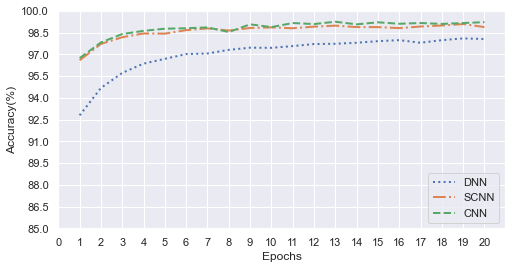

In [43]:
accuracys
print(accuracys)
plot_image(accuracys, './')

#### 2, Training on Noisy MNIST with AWGN dataset (n-MNIST-AWGN)

In [44]:
dataset = 'awgn' # mnist, awgn, motion-blur, reduced-contrast-and-awgn
epoch_num = 20
# accuracys_awgn,image_save_path = execute_train(dataset, epoch_num)

In [45]:
accuracys_awgn = [[89.5, 91.09, 92.22, 93.13, 93.7, 94.27, 94.65, 94.74, 94.95, 94.94, 95.11, 95.06, 95.28, 95.27, 95.25, 95.31, 95.44, 95.35, 95.44, 95.42], [92.95, 95.13, 95.53, 96.56, 97.24, 97.59, 97.42, 97.44, 97.84, 97.86, 97.69, 98.04, 97.86, 97.88, 97.92, 97.95, 97.99, 98.01, 97.93, 98.11], [95.21, 97.24, 97.47, 97.91, 98.06, 98.1, 98.32, 98.23, 98.26, 98.31, 98.43, 98.38, 98.42, 98.36, 98.45, 98.42, 98.36, 98.5, 98.53, 98.45]]

[[89.5, 91.09, 92.22, 93.13, 93.7, 94.27, 94.65, 94.74, 94.95, 94.94, 95.11, 95.06, 95.28, 95.27, 95.25, 95.31, 95.44, 95.35, 95.44, 95.42], [92.95, 95.13, 95.53, 96.56, 97.24, 97.59, 97.42, 97.44, 97.84, 97.86, 97.69, 98.04, 97.86, 97.88, 97.92, 97.95, 97.99, 98.01, 97.93, 98.11], [95.21, 97.24, 97.47, 97.91, 98.06, 98.1, 98.32, 98.23, 98.26, 98.31, 98.43, 98.38, 98.42, 98.36, 98.45, 98.42, 98.36, 98.5, 98.53, 98.45]]


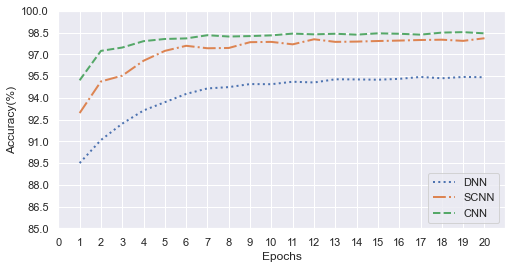

In [46]:
accuracys_awgn
print(accuracys_awgn)
plot_image(accuracys_awgn, './')

#### 3 Training on Noisy MNIST with Motion Blur dataset (n-MNIST-MB)

In [47]:
dataset = 'motion-blur' # mnist, awgn, motion-blur, reduced-contrast-and-awgn
epoch_num = 20
# accuracys_mb,image_save_path = execute_train(dataset, epoch_num)

In [48]:
accuracys_mb = [[91.56, 93.74, 94.93, 95.69, 96.07, 96.35, 96.74, 96.89, 97.02, 97.1, 97.07, 97.14, 97.45, 97.33, 97.36, 97.48, 97.51, 97.5, 97.62, 97.71], [94.6, 96.84, 96.82, 97.94, 97.9, 98.18, 98.34, 98.28, 98.44, 98.5, 98.39, 98.52, 98.66, 98.67, 98.58, 98.7, 98.65, 98.71, 98.69, 98.77], [95.52, 97.14, 98.03, 98.31, 98.38, 98.59, 98.68, 98.53, 98.64, 98.76, 98.93, 98.95, 98.9, 98.7, 98.95, 98.71, 98.93, 98.94, 99.02, 98.87]]

[[91.56, 93.74, 94.93, 95.69, 96.07, 96.35, 96.74, 96.89, 97.02, 97.1, 97.07, 97.14, 97.45, 97.33, 97.36, 97.48, 97.51, 97.5, 97.62, 97.71], [94.6, 96.84, 96.82, 97.94, 97.9, 98.18, 98.34, 98.28, 98.44, 98.5, 98.39, 98.52, 98.66, 98.67, 98.58, 98.7, 98.65, 98.71, 98.69, 98.77], [95.52, 97.14, 98.03, 98.31, 98.38, 98.59, 98.68, 98.53, 98.64, 98.76, 98.93, 98.95, 98.9, 98.7, 98.95, 98.71, 98.93, 98.94, 99.02, 98.87]]


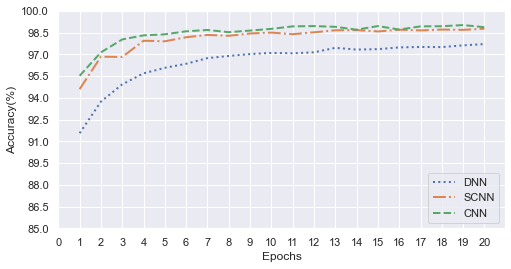

In [49]:
accuracys_mb
print(accuracys_mb)
plot_image(accuracys_mb, './')

#### 4, Training on Noisy MNIST with Reduced Contrast and AWGN dataset (n-MNIST-RC-AWGN)

In [50]:
dataset = 'reduced-contrast-and-awgn' # mnist, awgn, motion-blur, reduced-contrast-and-awgn
epoch_num = 20
# accuracys_rc_awgn,image_save_path = execute_train(dataset, epoch_num)

In [51]:
accuracys_rc_awgn = [[85.38, 86.67, 87.5, 87.84, 88.78, 89.38, 89.81, 90.47, 90.89, 91.11, 91.59, 91.83, 92.02, 91.94, 92.26, 92.21, 92.3, 92.54, 92.58, 92.72], [88.79, 91.93, 94.03, 93.74, 95.54, 95.14, 95.77, 95.68, 95.97, 96.27, 96.09, 96.18, 96.55, 96.27, 96.52, 96.56, 96.67, 96.64, 96.16, 96.72], [92.21, 94.9, 95.74, 96.16, 96.32, 96.42, 97.06, 97.06, 96.67, 97.09, 97.14, 96.94, 97.4, 97.46, 97.41, 97.48, 97.54, 97.37, 97.22, 97.31]]

[[85.38, 86.67, 87.5, 87.84, 88.78, 89.38, 89.81, 90.47, 90.89, 91.11, 91.59, 91.83, 92.02, 91.94, 92.26, 92.21, 92.3, 92.54, 92.58, 92.72], [88.79, 91.93, 94.03, 93.74, 95.54, 95.14, 95.77, 95.68, 95.97, 96.27, 96.09, 96.18, 96.55, 96.27, 96.52, 96.56, 96.67, 96.64, 96.16, 96.72], [92.21, 94.9, 95.74, 96.16, 96.32, 96.42, 97.06, 97.06, 96.67, 97.09, 97.14, 96.94, 97.4, 97.46, 97.41, 97.48, 97.54, 97.37, 97.22, 97.31]]


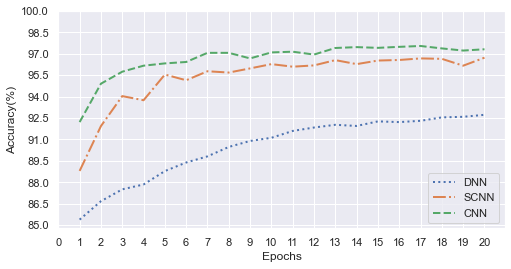

In [52]:
accuracys_rc_awgn
print(accuracys_rc_awgn)
plot_image(accuracys_rc_awgn, './')